In [1]:
import geopandas as gpd
import pandas as pd
from requests.auth import HTTPBasicAuth
import requests
import json
import plotly.express as px
import os
import rtree
import numpy as np
from shapely.geometry import Polygon

In [2]:
def make_grid(size):
    xmin, ymin, xmax, ymax = [-92.24149323, -26.86868477,  54.53053882,  27.29807282]

    length = size
    wide = size

    cols = list(np.arange(xmin, xmax + size, size))
    rows = list(np.arange(ymin, ymax + size, size))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+size, y), (x+size, y+length), (x, y+size)]))

    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid = grid.set_crs(epsg=4326)
    grid['centroid'] = grid.centroid
    grid = grid.to_crs(epsg=4326)
    return grid

In [3]:
#function that joins fewsnet data to grid
def join_to_grid(grid_gdf, polygon_file_list):
    fullgeo = gpd.GeoDataFrame()
    filenum = 1
    for url in polygon_file_list:
        print ("joining file " + str(filenum) + " " + str(url))
        tempgdf = gpd.read_file(url)
        tempgdf = tempgdf.to_crs(epsg=4326)
        year = url[-10:-6]
        month = url[-5:-3]
        tempgdf = tempgdf.rename(columns={'CS':year+'-'+month+'-CS'})
        # print column name
        print (year+'-'+month+'-CS')
        tempgdf = tempgdf.rename(columns={'HA0':year+'-'+month+'-HA0'})
        # the actual spatial join
        grid_gdf = grid_gdf.sjoin(tempgdf, how="left")
        print ("with duplicates dataframe is " + str(grid_gdf.shape))
        grid_gdf = grid_gdf.drop(columns=['index_right'])
        # print column names of grid_gdf
        print (grid_gdf.columns)
        # for duplicate centroid rows we keep the row with the higher CS value
        grid_gdf = grid_gdf.sort_values(by=[year+'-'+month+'-CS'], ascending=False)
        grid_gdf = grid_gdf.drop_duplicates(subset=['centroid'], keep='first')
        print ("duplicates removed " + str(grid_gdf.shape))
        filenum += 1
    return grid_gdf

ToDo
1. join all east africa data to one df and get the `df.totalbounds`
2. Create a grid based on these bounds
3. join each dataframe to the grid
4. export to geojson

In [17]:
# goes through each folder and creates a dictionary with file name and column names
# there is also a list created with just the file names for use later
# It adds each of the files with more metadata to the large_files list

large_files = []

# Central America files
cam_dict = {}
cam_files = "./data/ALL_HFIC/Central America and the Caribbean/" + os.listdir("./data/ALL_HFIC/Central America and the Caribbean")
for file in cam_files:
    if file.endswith(".shp"):
        tempgdf = gpd.read_file("./data/ALL_HFIC/Central America and the Caribbean/" + file)
        cam_dict[file] = tempgdf.columns
        if "ADMIN1" in tempgdf.columns:
            large_files.append(file)

# Central Asia files
cas_dict = {}
cas_files = "./data/ALL_HFIC/Central Asia/" + os.listdir("./data/ALL_HFIC/Central Asia")
for file in cas_files:
    if file.endswith(".shp"):
        tempgdf = gpd.read_file("./data/ALL_HFIC/Central Asia/" + file)
        cas_dict[file] = tempgdf.columns
        if "ADMIN1" in tempgdf.columns:
            large_files.append(file)

# East Africa files
ea_dict = {}
ea_files = []
for file in os.listdir("./data/ALL_HFIC/East Africa"):
    if file.endswith(".shp"):
        ea_files.append("./data/ALL_HFIC/East Africa/" + file)
for file in ea_files:
    tempgdf = gpd.read_file("./data/ALL_HFIC/East Africa/" + file)
    ea_dict[file] = tempgdf.columns
    if "ADMIN1" in tempgdf.columns:
        large_files.append(file)

# West Africa files
wa_dict = {}
wa_files = []
for file in os.listdir("./data/ALL_HFIC/West Africa"):
    if file.endswith(".shp"):
        wa_files.append("./data/ALL_HFIC/West Africa" + file)
for file in wa_files:
    tempgdf = gpd.read_file("./data/ALL_HFIC/West Africa/" + file)
    wa_dict[file] = tempgdf.columns
    if "ADMIN1" in tempgdf.columns:
        large_files.append(file)

# South Africa files
sa_dict = {}
sa_files = []
for file in os.listdir("./data/ALL_HFIC/Southern Africa"):
    if file.endswith(".shp"):
        sa_files.append("./data/ALL_HFIC/Southern Africa/" + file)
for file in sa_files:
    tempgdf = gpd.read_file(file)
    sa_dict[file] = tempgdf.columns
    if "ADMIN1" in tempgdf.columns:
        large_files.append(file)


In [18]:
url_list = []
for file in ea_files:
    if file.endswith(".shp"):
        beginning = "https://fdw.fews.net/api/ipcpackage/?country_group="
        code = "902"
        middle = "&collection_date="
        date = file[-13:-9] + "-" + file[-9:-7] + "-" + "01"
        url_list.append(beginning + code + middle + date)
for file in wa_files:
    if file.endswith(".shp"):
        beginning = "https://fdw.fews.net/api/ipcpackage/?country_group="
        code = "901"
        middle = "&collection_date="
        date = file[-13:-9] + "-" + file[-9:-7] + "-" + "01"
        url_list.append(beginning + code + middle + date)
for file in sa_files:
    if file.endswith(".shp"):
        beginning = "https://fdw.fews.net/api/ipcpackage/?country_group="
        code = "903"
        middle = "&collection_date="
        date = file[-13:-9] + "-" + file[-9:-7] + "-" + "01"
        url_list.append(beginning + code + middle + date)
for file in cam_files:
    if file.endswith(".shp"):
        beginning = "https://fdw.fews.net/api/ipcpackage/?country_group="
        code = "904"
        middle = "&collection_date="
        date = file[-13:-9] + "-" + file[-9:-7] + "-" + "01"
        url_list.append(beginning + code + middle + date)

In [24]:
url_list

['https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2018-02-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2019-02-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2021-06-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2020-06-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2019-10-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2018-10-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2010-01-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2011-01-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2013-10-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2012-10-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2015-04-01',
 'https://fdw.fews.net/api/ipcpackage/?country_group=9

In [23]:
x = 'https://fdw.fews.net/api/ipcpackage/?country_group=904&collection_date=2017-06-01'
print(x[-10:-6])
print(x[-5:-3])

2017
06


In [24]:
# this makes one giant geodataframe with all files' data in one place
# we'll use this to get bounds for our grid
# not doing central asia because it's only afghanistan and has a different naming schema
all_full = gpd.GeoDataFrame()
dateslist = []
error_files = []
for url in url_list:
    try:
        print (url)
        tempgdf = gpd.read_file(url)
        tempgdf = tempgdf.to_crs(epsg=4326)
        # add a column named year with the value filename[3:7]
        tempgdf["year"] = url[-10:-6]
        # last character of file
        tempgdf["month"] = url[-5:-3]
        dateslist.append(url[-10:-6]+'-'+url[-5:-3])
        # add tempgdf to ea_full
        all_full = all_full.append(tempgdf)
    except:
        print ("error reading " + url)
        error_files.append(url)
            
# grid_bounds = all_full.total_bounds

https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2018-02-01


/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_12081/3179312802.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_full = all_full.append(tempgdf)


https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2019-02-01


/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_12081/3179312802.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_full = all_full.append(tempgdf)


https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2021-06-01
error reading https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2021-06-01
https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2020-06-01


In [13]:
all_full

,cov_start,cov_end,report_mon,country,unit_name,ADMIN0,ADMIN1,ADMIN2,ADMIN3,LZCODE,...,ML1,HA1,fewsnet_re,geometry,year,month,ML2,HA2,CS,HA0
0,02-2018,05-2018,02-2018,KE,"Central Highlands, High Potential Zone, Buuri,...",Kenya,Meru,Buuri,None,KE19,...,1.0,0.0,East Africa,"POLYGON ((37.67888 0.14739, 37.67575 0.14754, ...",2018,02,NaN,NaN,NaN,NaN
1,02-2018,05-2018,02-2018,KE,"Central Highlands, High Potential Zone, Centra...",Kenya,Meru,Central Imenti,None,KE19,...,1.0,0.0,East Africa,"POLYGON ((37.80530 0.00274, 37.80227 -0.03663,...",2018,02,NaN,NaN,NaN,NaN
2,02-2018,05-2018,02-2018,KE,"Central Highlands, High Potential Zone, Chuka/...",Kenya,Tharaka Nithi,Chuka/Igambang'Ombe,None,KE19,...,1.0,0.0,East Africa,"POLYGON ((37.76675 -0.29604, 37.76242 -0.31192...",2018,02,NaN,NaN,NaN,NaN
3,02-2018,05-2018,02-2018,KE,"Central Highlands, High Potential Zone, Dagore...",Kenya,Nairobi,Dagoretti North,None,KE19,...,1.0,0.0,East Africa,"POLYGON ((36.81236 -1.27503, 36.81236 -1.27507...",2018,02,NaN,NaN,NaN,NaN
4,02-2018,05-2018,02-2018,KE,"Central Highlands, High Potential Zone, Dagore...",Kenya,Nairobi,Dagoretti South,None,KE19,...,1.0,0.0,East Africa,"POLYGON ((36.71942 -1.26371, 36.72013 -1.26444...",2018,02,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,06-2017,09-2017,06-2017,GT,"Zacualpa, Quiche, Guatemala",Guatemala,Quiche,Zacualpa,None,None,...,3.0,0,Central America and Caribbean,"POLYGON ((-90.80677 15.15615, -90.80458 15.152...",2017,06,NaN,NaN,NaN,NaN
326,06-2017,09-2017,06-2017,GT,"Zapotitlan, Jutiapa, Guatemala",Guatemala,Jutiapa,Zapotitlan,None,None,...,3.0,0,Central America and Caribbean,"POLYGON ((-89.78075 14.09604, -89.78215 14.090...",2017,06,NaN,NaN,NaN,NaN
327,06-2017,09-2017,06-2017,GT,"Zaragoza, Chimaltenango, Guatemala",Guatemala,Chimaltenango,Zaragoza,None,None,...,1.0,0,Central America and Caribbean,"POLYGON ((-90.81254 14.72340, -90.81261 14.722...",2017,06,NaN,NaN,NaN,NaN
328,06-2017,09-2017,06-2017,GT,"Zunilito, Suchitepequez, Guatemala",Guatemala,Suchitepequez,Zunilito,None,None,...,1.0,0,Central America and Caribbean,"POLYGON ((-91.50648 14.60012, -91.50864 14.600...",2017,06,NaN,NaN,NaN,NaN


In [12]:
grid_bounds = [-92.24149323, -26.86868477,  54.53053882,  27.29807282]
grid_bounds

array([-92.24149323, -26.86868477,  54.53053882,  27.29807282])

In [19]:
full_grid = make_grid(0.1)
full_grid = full_grid.set_geometry('centroid')



/var/folders/3v/8xxt4zw96bn2l6qwb8w7_5r40000gn/T/ipykernel_13109/1231606257.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid['centroid'] = grid.centroid


In [14]:
full_grid

,geometry,centroid
0,"POLYGON ((-92.24149 -26.86868, -92.14149 -26.8...",POINT (-92.19149 -26.81868)
1,"POLYGON ((-92.24149 -26.76868, -92.14149 -26.7...",POINT (-92.19149 -26.71868)
2,"POLYGON ((-92.24149 -26.66868, -92.14149 -26.6...",POINT (-92.19149 -26.61868)
3,"POLYGON ((-92.24149 -26.56868, -92.14149 -26.5...",POINT (-92.19149 -26.51868)
4,"POLYGON ((-92.24149 -26.46868, -92.14149 -26.4...",POINT (-92.19149 -26.41868)
...,...,...
795651,"POLYGON ((54.45851 26.83132, 54.55851 26.83132...",POINT (54.50851 26.88132)
795652,"POLYGON ((54.45851 26.93132, 54.55851 26.93132...",POINT (54.50851 26.98132)
795653,"POLYGON ((54.45851 27.03132, 54.55851 27.03132...",POINT (54.50851 27.08132)
795654,"POLYGON ((54.45851 27.13132, 54.55851 27.13132...",POINT (54.50851 27.18132)


In [16]:
url_list


[]

In [22]:
full_grid = join_to_grid(full_grid, url_list)

joining file 1 https://fdw.fews.net/api/ipcpackage/?country_group=902&collection_date=2018-02-01
2018-02-CS
with duplicates dataframe is (795732, 17)
Index(['geometry', 'centroid', 'cov_start', 'cov_end', 'report_mon', 'country',
       'unit_name', 'ADMIN0', 'ADMIN1', 'ADMIN2', 'ADMIN3', 'LZCODE', 'LZNAME',
       'ML1', 'HA1', 'fewsnet_re'],
      dtype='object')


KeyError: '2018-02-CS'

In [22]:
ea_grid

,geometry,centroid,2018-02-CS,2018-02-HA0,2019-02-CS,2019-02-HA0,2021-06-CS,2021-06-HA0,2020-06-CS,2020-06-HA0,...,2014-01-CS,2014-01-HA0,2015-01-CS,2015-01-HA0,2013-07-CS,2013-07-HA0,2012-07-CS,2012-07-HA0,2011-04-CS,2010-04-CS
60958,"POLYGON ((39.23895 -5.96007, 39.33895 -5.96007...",POINT (39.28895 -5.91007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,99.0
62713,"POLYGON ((39.73895 -5.46007, 39.83895 -5.46007...",POINT (39.78895 -5.41007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,99.0
61852,"POLYGON ((39.43895 13.43993, 39.53895 13.43993...",POINT (39.48895 13.48993),1.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,3.0,0.0,2.0,0.0,2.0,99.0
62716,"POLYGON ((39.73895 -5.16007, 39.83895 -5.16007...",POINT (39.78895 -5.11007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,99.0
59356,"POLYGON ((38.73895 8.83993, 38.83895 8.83993, ...",POINT (38.78895 8.88993),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,99.0,99.0,1.0,0.0,99.0,99.0,99.0,99.0,99.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114445,"POLYGON ((54.43895 22.73993, 54.53895 22.73993...",POINT (54.48895 22.78993),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114446,"POLYGON ((54.43895 22.83993, 54.53895 22.83993...",POINT (54.48895 22.88993),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114447,"POLYGON ((54.43895 22.93993, 54.53895 22.93993...",POINT (54.48895 22.98993),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114448,"POLYGON ((54.43895 23.03993, 54.53895 23.03993...",POINT (54.48895 23.08993),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
ea_grid_proof = ea_grid

In [24]:
# cleaning up the grid
# for columns in ea_grid that end in cs if value is 88 or 99 delete that value
# from what I can gather 88 and 99 are used to indicate missing data in FEWSNET
for col in ea_grid.columns:
    if col.endswith('-CS'):
        ea_grid[col] = ea_grid[col].replace(88, np.nan)
        ea_grid[col] = ea_grid[col].replace(99, np.nan)
# deleting rows that are just NaN values
ea_grid = ea_grid.dropna(axis=0, how='all', subset=ea_grid.iloc[:,3:93].columns)
# switching geometry from centroid column to geometry column. geometry is the column containing our tile squares. 
ea_grid = ea_grid.set_geometry('geometry')
ea_grid_nocentroid = ea_grid.drop(columns=['centroid'])


In [25]:
# write ea_grid_nocentroid to geojson
ea_grid_nocentroid.to_file("./data/join_experiments/ea_grid_1.geojson", driver='GeoJSON')


In [26]:
ea_grid.head(5)

,geometry,centroid,2018-02-CS,2018-02-HA0,2019-02-CS,2019-02-HA0,2021-06-CS,2021-06-HA0,2020-06-CS,2020-06-HA0,...,2014-01-CS,2014-01-HA0,2015-01-CS,2015-01-HA0,2013-07-CS,2013-07-HA0,2012-07-CS,2012-07-HA0,2011-04-CS,2010-04-CS
61852,"POLYGON ((39.43895 13.43993, 39.53895 13.43993...",POINT (39.48895 13.48993),1.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,3.0,0.0,2.0,0.0,2.0,NaN
59356,"POLYGON ((38.73895 8.83993, 38.83895 8.83993, ...",POINT (38.78895 8.88993),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,99.0,1.0,0.0,NaN,99.0,NaN,99.0,NaN,NaN
59707,"POLYGON ((38.83895 8.93993, 38.93895 8.93993, ...",POINT (38.88895 8.98993),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,99.0,1.0,0.0,NaN,99.0,NaN,99.0,NaN,NaN
59007,"POLYGON ((38.63895 8.93993, 38.73895 8.93993, ...",POINT (38.68895 8.98993),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,99.0,1.0,0.0,NaN,99.0,NaN,99.0,NaN,NaN
59357,"POLYGON ((38.73895 8.93993, 38.83895 8.93993, ...",POINT (38.78895 8.98993),1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,99.0,1.0,0.0,NaN,99.0,NaN,99.0,NaN,NaN


<AxesSubplot: >

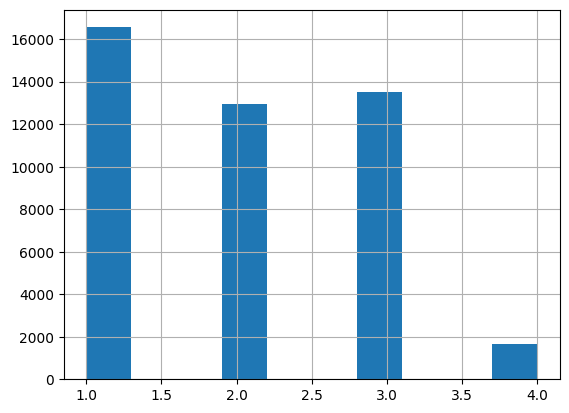

In [27]:
# histogram of values in 2018-02-CS column
ea_grid['2018-02-CS'].hist()

In [28]:
# drop columns that end in ha0

csgrid = ea_grid.drop(columns=ea_grid.columns[ea_grid.columns.str.endswith('-HA0')])
csgrid

,geometry,centroid,2018-02-CS,2019-02-CS,2021-06-CS,2020-06-CS,2019-10-CS,2018-10-CS,2010-01-CS,2011-01-CS,...,2017-10-CS,2016-10-CS,2016-02-CS,2017-02-CS,2014-01-CS,2015-01-CS,2013-07-CS,2012-07-CS,2011-04-CS,2010-04-CS
61852,"POLYGON ((39.43895 13.43993, 39.53895 13.43993...",POINT (39.48895 13.48993),1.0,1.0,3.0,1.0,1.0,2.0,NaN,2.0,...,2.0,1.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,NaN
59356,"POLYGON ((38.73895 8.83993, 38.83895 8.83993, ...",POINT (38.78895 8.88993),1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
59707,"POLYGON ((38.83895 8.93993, 38.93895 8.93993, ...",POINT (38.88895 8.98993),1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
59007,"POLYGON ((38.63895 8.93993, 38.73895 8.93993, ...",POINT (38.68895 8.98993),1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
59357,"POLYGON ((38.73895 8.93993, 38.83895 8.93993, ...",POINT (38.78895 8.98993),1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58643,"POLYGON ((38.53895 7.53993, 38.63895 7.53993, ...",POINT (38.58895 7.58993),NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58642,"POLYGON ((38.53895 7.43993, 38.63895 7.43993, ...",POINT (38.58895 7.48993),NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26334,"POLYGON ((29.33895 -3.36007, 29.43895 -3.36007...",POINT (29.38895 -3.31007),NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26677,"POLYGON ((29.43895 -4.06007, 29.53895 -4.06007...",POINT (29.48895 -4.01007),NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# sort columns by name csgrid
csgrid = csgrid.sort_index(axis=1)

In [30]:
csgrid

,2009-07-CS,2009-10-CS,2010-01-CS,2010-04-CS,2010-07-CS,2010-10-CS,2011-01-CS,2011-04-CS,2011-07-CS,2011-10-CS,...,ADMIN3,LZCODE,LZNAME,centroid,country,cov_end,cov_start,geometry,report_mon,unit_name
61852,NaN,NaN,NaN,NaN,3.0,3.0,2.0,2.0,2.0,2.0,...,Mekelle,None,None,POINT (39.48895 13.48993),ET,10-2021,10-2021,"POLYGON ((39.43895 13.43993, 39.53895 13.43993...",10-2021,"Mekelle, Mekelle, Tigray, Ethiopia"
59356,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,...,Akaki - Kalit,None,None,POINT (38.78895 8.88993),ET,10-2021,10-2021,"POLYGON ((38.73895 8.83993, 38.83895 8.83993, ...",10-2021,"Akaki - Kalit, Region 14, Addis Ababa, Ethiopia"
59707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Bole,None,None,POINT (38.88895 8.98993),ET,10-2021,10-2021,"POLYGON ((38.83895 8.93993, 38.93895 8.93993, ...",10-2021,"Bole, Region 14, Addis Ababa, Ethiopia"
59007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Kolfe - Keran,None,None,POINT (38.68895 8.98993),ET,10-2021,10-2021,"POLYGON ((38.63895 8.93993, 38.73895 8.93993, ...",10-2021,"Kolfe - Keran, Region 14, Addis Ababa, Ethiopia"
59357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Bole,None,None,POINT (38.78895 8.98993),ET,10-2021,10-2021,"POLYGON ((38.73895 8.93993, 38.83895 8.93993, ...",10-2021,"Bole, Region 14, Addis Ababa, Ethiopia"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Arsi Negele,None,None,POINT (38.58895 7.58993),ET,10-2021,10-2021,"POLYGON ((38.53895 7.53993, 38.63895 7.53993, ...",10-2021,"Arsi Negele, West Arsi, Oromia, Ethiopia"
58642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Arsi Negele,None,None,POINT (38.58895 7.48993),ET,10-2021,10-2021,"POLYGON ((38.53895 7.43993, 38.63895 7.43993, ...",10-2021,"Arsi Negele, West Arsi, Oromia, Ethiopia"
26334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,BI07,Imbo Plain,POINT (29.38895 -3.31007),BI,10-2021,10-2021,"POLYGON ((29.33895 -3.36007, 29.43895 -3.36007...",10-2021,"Imbo Plain, Bujumbura Rural, Burundi"
26677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,BI07,Imbo Plain,POINT (29.48895 -4.01007),BI,10-2021,10-2021,"POLYGON ((29.43895 -4.06007, 29.53895 -4.06007...",10-2021,"Imbo Plain, Rumonge, Burundi"


In [38]:
# create a dataframe of only columns that end in cs
csgrid = csgrid.filter(regex='CS$', axis=1)
# csgrid = csgrid.fillna(method='ffill', axis=1)

In [45]:
csgrid = csgrid.fillna(method='bfill', axis=1)

In [47]:
# replace columns in ea_grid with csgrid
ea_grid = ea_grid.drop(columns=ea_grid.columns[ea_grid.columns.str.endswith('-CS')])
ea_grid = ea_grid.join(csgrid)


In [49]:
ea_grid_nocentroid = ea_grid.drop(columns=['centroid'])
ea_grid_nocentroid.to_file("./data/join_experiments/ea_grid_1_bfill.geojson", driver='GeoJSON')